In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import sqlite3

In [16]:
forecast = pd.read_csv('/Users/pep/Downloads/Great_Outdoors_Data_SQLite/GO_SALES_INVENTORY_LEVELSData.csv', index_col=False)
inventory = pd.read_csv('/Users/pep/Downloads/Great_Outdoors_Data_SQLite/GO_SALES_PRODUCT_FORECASTData.csv' )

conn = sqlite3.connect('/Users/pep/Downloads/Great_Outdoors_Data_SQLite/go_sales.sqlite')
details = pd.read_sql(con=conn, sql='SELECT * FROM order_details')
header = pd.read_sql(con=conn, sql='SELECT * FROM order_header')
product = pd.read_sql_query("SELECT * FROM product;", conn)

details = details.drop(columns=['TRIAL879'])
header = header.drop(columns=['TRIAL885'])

In [17]:
order = pd.merge(header, details, on='ORDER_NUMBER')
order

,ORDER_NUMBER,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,ORDER_DETAIL_CODE,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE
0,1153,Ultra Sports,4,6,50,18,2020-04-14,7,47747,2,100,9.64,12.53,11.81
1,1153,Ultra Sports,4,6,50,18,2020-04-14,7,47994,32,254,18.25,27.37,25.1
2,1153,Ultra Sports,4,6,50,18,2020-04-14,7,48015,35,114,19.67,26.54,24.82
3,1153,Ultra Sports,4,6,50,18,2020-04-14,7,48022,36,130,21.03,34.9,31.44
4,1153,Ultra Sports,4,6,50,18,2020-04-14,7,48049,39,74,42.33,67.73,61.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110788,52,64,19,38,33.25
43059,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110816,56,24,9,18,15.75
43060,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110827,57,40,40,80,70
43061,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110914,78,32,79.19,99,94.05


In [18]:
# Selecteren van onafhankelijke variabelen en afhankelijke variabele
order['YEAR'] = order['ORDER_DATE'].astype(str).str.split("-").str.get(0)
order['MONTH'] = order['ORDER_DATE'].astype(str).str.split("-").str.get(1)
order['MONTH'] = order['MONTH'].str.replace("0","")

# Laat onnodige kolommen vallen
order = order[['PRODUCT_NUMBER', 'QUANTITY', 'YEAR', 'MONTH']]
order

,PRODUCT_NUMBER,QUANTITY,YEAR,MONTH
0,2,100,2020,4
1,32,254,2020,4
2,35,114,2020,4
3,36,130,2020,4
4,39,74,2020,4
...,...,...,...,...
43058,52,64,2022,2
43059,56,24,2022,2
43060,57,40,2022,2
43061,78,32,2022,2


In [19]:
order = order.groupby(['PRODUCT_NUMBER', 'YEAR', 'MONTH'])
order = order.aggregate('sum').reset_index()

order

,PRODUCT_NUMBER,YEAR,MONTH,QUANTITY
0,1,2020,1,1790
1,1,2020,11,460
2,1,2020,12,872
3,1,2020,2,344
4,1,2020,3,898
...,...,...,...,...
3544,99,2022,5,466
3545,99,2022,6,598
3546,99,2022,7,264
3547,99,2022,8,264


In [20]:
inventory = inventory.rename(columns={'INVENTORY_MONTH':'MONTH','INVENTORY_YEAR':'YEAR'})
forecast = forecast.rename(columns={'INVENTORY_MONTH':'MONTH','INVENTORY_YEAR':'YEAR'})
df = pd.merge(forecast, inventory, on=['MONTH', 'YEAR', 'PRODUCT_NUMBER'])

df['PRODUCT_NUMBER'] = df['PRODUCT_NUMBER'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)
df['YEAR'] = df['YEAR'].astype(int)
order['PRODUCT_NUMBER'] = order['PRODUCT_NUMBER'].astype(int)
order['MONTH'] = order['MONTH'].astype(int)
order['YEAR'] = order['YEAR'].astype(int)

df = pd.merge(order, df, on=['MONTH', 'YEAR', 'PRODUCT_NUMBER'])

In [21]:
product['PRODUCT_NUMBER'] = product['PRODUCT_NUMBER'].astype(int)
product['PRODUCTION_COST'] = product['PRODUCTION_COST'].astype(float)
product['MARGIN'] = product['MARGIN'].astype(float)
product = product[['PRODUCT_NUMBER', 'PRODUCTION_COST', 'PRODUCT_TYPE_CODE', 'MARGIN']]

df = pd.merge(product, df, on='PRODUCT_NUMBER')

df

,PRODUCT_NUMBER,PRODUCTION_COST,PRODUCT_TYPE_CODE,MARGIN,YEAR,MONTH,QUANTITY,INVENTORY_COUNT,EXPECTED_VOLUME
0,1,4.0,1,0.33,2020,1,1790,2007,524
1,1,4.0,1,0.33,2020,11,460,1829,390
2,1,4.0,1,0.33,2020,12,872,2157,640
3,1,4.0,1,0.33,2020,2,344,2263,403
4,1,4.0,1,0.33,2020,3,898,1965,750
...,...,...,...,...,...,...,...,...,...
3543,99,2.0,17,0.60,2022,5,466,5163,519
3544,99,2.0,17,0.60,2022,6,598,4565,701
3545,99,2.0,17,0.60,2022,7,264,4301,327
3546,99,2.0,17,0.60,2022,8,264,4037,299


In [22]:
df['MONTH'] = df['MONTH'].astype(str)
month_dummies = pd.get_dummies(df.loc[:,['MONTH']])

df = pd.concat([df, month_dummies], axis=1)
df.drop(['MONTH'], axis=1)


df['PRODUCT_TYPE_CODE'] = df['PRODUCT_TYPE_CODE'].astype(str)
product_line_dummies = pd.get_dummies(df.loc[:,['PRODUCT_TYPE_CODE']])

df = pd.concat([df, product_line_dummies], axis=1)
df.drop(['PRODUCT_TYPE_CODE'], axis=1)

df.drop(['PRODUCT_NUMBER'], axis=1)

df = df.rename(columns=str.lower)
df

,product_number,production_cost,product_type_code,margin,year,month,quantity,inventory_count,expected_volume,month_1,...,product_type_code_2,product_type_code_20,product_type_code_21,product_type_code_3,product_type_code_4,product_type_code_5,product_type_code_6,product_type_code_7,product_type_code_8,product_type_code_9
0,1,4.0,1,0.33,2020,1,1790,2007,524,True,...,False,False,False,False,False,False,False,False,False,False
1,1,4.0,1,0.33,2020,11,460,1829,390,False,...,False,False,False,False,False,False,False,False,False,False
2,1,4.0,1,0.33,2020,12,872,2157,640,False,...,False,False,False,False,False,False,False,False,False,False
3,1,4.0,1,0.33,2020,2,344,2263,403,False,...,False,False,False,False,False,False,False,False,False,False
4,1,4.0,1,0.33,2020,3,898,1965,750,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,99,2.0,17,0.60,2022,5,466,5163,519,False,...,False,False,False,False,False,False,False,False,False,False
3544,99,2.0,17,0.60,2022,6,598,4565,701,False,...,False,False,False,False,False,False,False,False,False,False
3545,99,2.0,17,0.60,2022,7,264,4301,327,False,...,False,False,False,False,False,False,False,False,False,False
3546,99,2.0,17,0.60,2022,8,264,4037,299,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
x = df.drop('quantity', axis=1)
y = df.loc[:,['quantity']]
x

,product_number,production_cost,product_type_code,margin,year,month,inventory_count,expected_volume,month_1,month_11,...,product_type_code_2,product_type_code_20,product_type_code_21,product_type_code_3,product_type_code_4,product_type_code_5,product_type_code_6,product_type_code_7,product_type_code_8,product_type_code_9
0,1,4.0,1,0.33,2020,1,2007,524,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1,4.0,1,0.33,2020,11,1829,390,False,True,...,False,False,False,False,False,False,False,False,False,False
2,1,4.0,1,0.33,2020,12,2157,640,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,4.0,1,0.33,2020,2,2263,403,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,4.0,1,0.33,2020,3,1965,750,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,99,2.0,17,0.60,2022,5,5163,519,False,False,...,False,False,False,False,False,False,False,False,False,False
3544,99,2.0,17,0.60,2022,6,4565,701,False,False,...,False,False,False,False,False,False,False,False,False,False
3545,99,2.0,17,0.60,2022,7,4301,327,False,False,...,False,False,False,False,False,False,False,False,False,False
3546,99,2.0,17,0.60,2022,8,4037,299,False,False,...,False,False,False,False,False,False,False,False,False,False


In [93]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.05, 
    random_state=12
    )

In [94]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train,y_train)
reg_model

LinearRegression()

In [95]:
y_pred = reg_model.predict(x_test)
y_pred

array([[ 3.32772440e+02],
       [ 5.23455406e+00],
       [ 1.02527851e+02],
       [ 3.62189590e+02],
       [ 8.38608230e+02],
       [ 1.57235612e+02],
       [ 1.77498668e+02],
       [ 4.11223640e+01],
       [ 2.79410355e+02],
       [-9.84771052e+01],
       [ 1.28325632e+03],
       [ 6.94973680e+02],
       [ 1.57521041e+02],
       [ 1.34847411e+02],
       [ 4.76337329e+02],
       [ 1.12300764e+02],
       [ 9.46327918e+01],
       [ 3.52288112e+02],
       [ 2.97668574e+02],
       [ 2.11520240e+03],
       [ 1.26083606e+03],
       [ 1.30739448e+03],
       [ 5.13608813e+02],
       [ 8.61107307e+02],
       [ 3.56745548e+02],
       [ 1.45829816e+02],
       [ 6.77897458e+01],
       [ 3.42957140e+02],
       [ 8.66556665e+02],
       [ 7.26655475e+01],
       [ 1.85311755e+02],
       [ 2.48837461e+03],
       [ 2.68086214e+03],
       [ 1.35676031e+02],
       [ 1.43644247e+02],
       [ 3.58860355e+02],
       [ 1.62708246e+03],
       [ 1.21135931e+02],
       [ 1.4

In [96]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns={0: 'predicted_quantity'})
prediction_df

,predicted_quantity
0,332.772440
1,5.234554
2,102.527851
3,362.189590
4,838.608230
...,...
173,325.244378
174,870.371950
175,619.030371
176,1016.578008


In [97]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['quantity'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['predicted_quantity'].notna(),:]

,quantity,predicted_quantity
0,336,332.772440
1,138,5.234554
2,132,102.527851
3,396,362.189590
4,690,838.608230
...,...,...
173,326,325.244378
174,1080,870.371950
175,570,619.030371
176,838,1016.578008


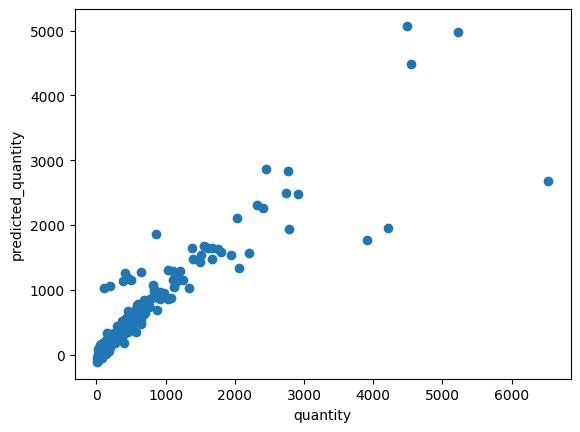

In [101]:
plt.scatter(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])
plt.xlabel('quantity')
plt.ylabel('predicted_quantity')
plt.show()

In [99]:
mean_squared_error(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])

190497.99345509938

In [100]:
mean_absolute_error(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])

176.89115696081868